In [51]:
# get_ipython().magic('matplotlib notebook')
get_ipython().magic('matplotlib inline')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import shapefile as shp
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
xr.set_options(keep_attrs=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/tmp/ipykernel_2925859/3838599388.py:2: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('matplotlib inline')
/tmp/ipykernel_2925859/3838599388.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('load_ext autoreload')
/tmp/ipykernel_2925859/3838599388.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('autoreload 2')


In [52]:
# Parameters
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= None #5 # set None --> take path as in input_paths otherwise add dir of cycle
which_mode= 'mhflx' # global heat flux

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/')
# input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')

input_names= list()
# input_names.append('TKE+IDEMIX, jayne')
# input_names.append('TKE+IDEMIX, nycander')
# input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'mhflx'
# year      = [1979,2019]
year      = [1970,1980]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
box_region = list()
box_region.append('global')
box_region.append('moc_basins/Atlantic_MOC.shp')
box_region.append('moc_basins/IndoPacific_MOC.shp')
# box_region.append('ocean_basins/Atlantic_Basin.shp')
# box_region.append('ocean_basins/Pacific_Basin.shp')

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/' # None
ref_name  = None # 'TKE, ck=0.1' # None
ref_year  = None # [2009,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
cstr, cnum = 'blue2red', 20
cref, crange, cmin, cmax, cfac, climit = None, None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
which_dpi = 300
do_allcycl= False
use_advflx= True # True: compute hflux from u*t and v*t, False: compute hflx from u, v, temp, (u_bolus, v_bolus)
use_bolusv= True
do_edgevec_r2g = False


In [53]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True,
                      do_earea=True, do_narea=True, do_eresol=[True,'mean'], do_nresol=[True,'eresol'])

#______________________________________________________________________________________________________
if (which_cycl is not None) and (which_cycl is not "None"): 
    #__________________________________________________________________________________________________
    if do_allcycl: cycl_s=1
    else         : cycl_s=which_cycl    
    
    #__________________________________________________________________________________________________
    aux_path, aux_name = list(), list()
    input_paths_old, input_names_old = input_paths, input_names
    for ii, (ipath,iname) in enumerate(zip(input_paths,input_names)):
        for ii_cycl in range(cycl_s, which_cycl+1):
            # input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
            aux_path.append(os.path.join(ipath,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(iname))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, iname))
            print(ii, aux_path[-1],aux_name[-1])
    input_paths, input_names = aux_path, aux_name
    
    #__________________________________________________________________________________________________
    if (ref_path is not None) and (ref_path is not "None"): 
        aux_path, aux_name = list(), list()
        ref_path_old, ref_name_old = ref_path, ref_name
        for ii_cycl in range(cycl_s, which_cycl+1):
            #ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
            aux_path.append(os.path.join(ref_path,'{:d}/'.format(ii_cycl)))
            if not do_allcycl: aux_name.append('{}'.format(ref_name))
            else             : aux_name.append('{:d}) {}'.format(ii_cycl, ref_name))
            print('R', ref_path[-1])        
        ref_path, ref_name = aux_path, aux_name
    del(aux_path, aux_name)
    

#______________________________________________________________________________________________________
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path is not None) and (ref_path is not "None"): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)
else:
    do_reffig=False

#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path is not None) and (ref_path is not "None"): 
    if isinstance(ref_path, list): 
        input_paths, input_names = input_paths + ref_path, input_names + ref_name 
    else:    
        input_paths, input_names = input_paths + list([ref_path]), input_names + list([ref_name])
        
#______________________________________________________________________________________________________
box = list()
shp_path = os.path.join(tpv.__path__[0],'shapefiles/')
for region in box_region:
    if region is 'global' or isinstance(region,list): box.append(region)
    else: box.append(shp.Reader(os.path.join(shp_path,region)))        

<>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:24: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:40: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:51: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:61: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:24: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:40: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:51: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:61: SyntaxWarning: "is" with a literal. Did you mean "=="?
/albedo/home/pscholz/tripyview/tripyview/sub_mesh.py:106: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  mesh = pickle.load(fid)


 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node_focus0.pckl
 > comp. e_resol from mean
 > comp n_resol from e_resol
___FESOM2 MESH INFO________________________
 > path            = /work/ollie/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, True
 > do narea,nresol = True, True
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


/albedo/home/pscholz/tripyview/tripyview/sub_mesh.py:928: RuntimeWarning: divide by zero encountered in divide
  self.n_resol=self.n_resol/self.n_area/3.0
/tmp/ipykernel_2925859/464115329.py:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if (which_cycl is not None) and (which_cycl is not "None"):
/tmp/ipykernel_2925859/464115329.py:24: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if (ref_path is not None) and (ref_path is not "None"):
/tmp/ipykernel_2925859/464115329.py:40: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if (ref_path is not None) and (ref_path is not "None"):
/tmp/ipykernel_2925859/464115329.py:51: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if (ref_path is not None) and (ref_path is not "None"):
/tmp/ipykernel_2925859/464115329.py:61: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if region is 'global' or isinstance(region,list): box.append(region)


In [54]:
datapath = input_paths[0]
#___________________________________________________________________________
# load information about edges 
fname = 'fesom.mesh.diag.nc'
# check for directory with diagnostic file
if   os.path.isfile( os.path.join(datapath, fname) ): 
    dname = datapath
elif os.path.isfile( os.path.join( os.path.join(os.path.dirname(os.path.normpath(datapath)),'1/'), fname) ): 
    dname = os.path.join(os.path.dirname(os.path.normpath(datapath)),'1/')
elif os.path.isfile( os.path.join(mesh.path,fname) ): 
    dname = mesh.path
else:
    raise ValueError('could not find directory with...mesh.diag.nc file')    

# load diag file
meshdiag = xr.open_dataset(os.path.join(dname,fname))
# node indices of edge points [2 x n2ded]
edge     =meshdiag['edges'].values-1
# element indices of triangles that are left and right of edg: [2 x n2ded]
edge_tri =meshdiag['edge_tri'].values-1
# dx & dy of edge midpoints towards element centroid of left and right triangle
edge_dxdy=meshdiag['edge_cross_dxdy'].values[:]

# # dx & dy of left triangle --> norm vector [L]eft
# edge_dxdy_l=np.array([ edge_dxdy[1,:], -edge_dxdy[0,:]])
# # dx & dy of right triangle --> norm vector [R]ight
# edge_dxdy_r=np.array([-edge_dxdy[3,:],  edge_dxdy[2,:]])
# edge_dxdy_r[:, edge_tri[1,:]<0]=0. # if boundarie edge --> right triangle doesnot exist

if (do_edgevec_r2g):
    edm_x = mesh.n_x[edge].sum(axis=0)/2.0
    edm_y = mesh.n_y[edge].sum(axis=0)/2.0
    edge_dxdy[0,:], edge_dxdy[1,:] = tpv.vec_r2g(mesh.abg, edm_x, edm_y, edge_dxdy[0,:], edge_dxdy[1,:], gridis='geo', do_info=False )
    edge_dxdy[2,:], edge_dxdy[3,:] = tpv.vec_r2g(mesh.abg, edm_x, edm_y, edge_dxdy[2,:], edge_dxdy[3,:], gridis='geo', do_info=False )
    del(edm_x, edm_y)

# dx & dy of left triangle
edge_dxdy_l=np.array([ edge_dxdy[1,:], -edge_dxdy[0,:]])
# dx & dy of right triangle
edge_dxdy_r=np.array([ -edge_dxdy[3,:], edge_dxdy[2,:]])
edge_dxdy_r[:, edge_tri[1,:]<0]=0. # if boundarie edge --> right triangle doesnot exist

In [55]:
#___LOAD FESOM2 DATA___________________________________________________________________________________
# load t*u and t*v together
hflx_list = list()
for datapath, descript in zip(input_paths, input_names): 
    print(datapath, descript)
    if use_advflx:
        #__________________________________________________________________________________________________
        data = tpv.load_data_fesom2(mesh, datapath, vname='vec+tu+tv', year=year, descript=descript, 
                                    do_info=False, do_vecrot=False, do_zarithm='None', do_ie2n=False)
        
        #__________________________________________________________________________________________________    
        # check if data where loaded
        if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
        
        #__________________________________________________________________________________________________
        # compute meridional heat flux from t*v by binning
        hflx_list.append(tpv.calc_mhflx_box(mesh, data, box, edge, edge_tri, edge_dxdy_l, edge_dxdy_r, dlat=1.0))
        del(data)
    else: 
        #__________________________________________________________________________________________________
        # load velocities
        data = tpv.load_data_fesom2(mesh, datapath, vname='vec+u+v', year=year, descript=descript, 
                                        do_info=False, do_vecrot=False, do_zarithm='None', do_ie2n=False)
        
        #__________________________________________________________________________________________________    
        # check if data where loaded
        if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    
        #__________________________________________________________________________________________________    
        if use_bolusv:
            data['u'].data = data['u'].data + tpv.load_data_fesom2(mesh, datapath, vname='bolus_u', year=year, descript=descript, 
                                                                   do_info=False, do_vecrot=False, do_zarithm='None', do_ie2n=False)['bolus_u'].data
            data['v'].data = data['v'].data + tpv.load_data_fesom2(mesh, datapath, vname='bolus_v', year=year, descript=descript, 
                                                                   do_info=False, do_vecrot=False, do_zarithm='None', do_ie2n=False)['bolus_v'].data
            
        #__________________________________________________________________________________________________
        # load temperature
        datat = tpv.load_data_fesom2(mesh, datapath, vname='temp', year=year, descript=descript, 
                                        do_info=False, do_vecrot=False, do_zarithm='None', do_ie2n=False)
        #__________________________________________________________________________________________________
        # compute meridional heat flux from t*v by binning
        hflx_list.append(tpv.calc_mhflx_box(mesh, data, box, edge, edge_tri, edge_dxdy_l, edge_dxdy_r, datat=datat, dlat=1.0))
        del(data)

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE
Atlantic
IndoPacific


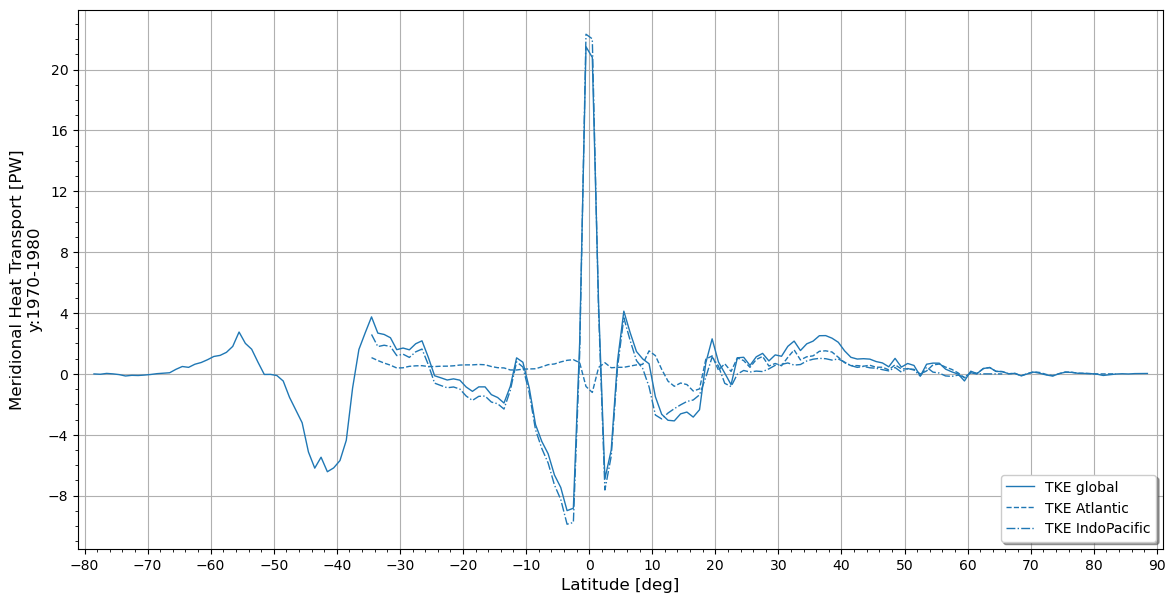

In [56]:
# #___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = list(hflx_list[0][0].keys())[0]
slabel = hflx_list[0][0][sname].attrs['str_lsave']
if spath is not None: spath  = os.path.join(spath,'{}_{}_{}.png'.format(which_mode, sname, slabel)) 
if save_fname is not None: spath = save_fname
fig, ax = tpv.plot_mhflx(hflx_list, input_names, sect_name=None, figsize=[7*2, 3.5*2], 
                         do_allcycl=False, do_save=spath, save_dpi=which_dpi,)